# AutoML Exercise

## 1. Introduction

In this exercise we will see how we can use Bayesian optimization [[Shahriari et al, 2016]](#4.-References) and Regularized Evolution [[Real et al. 2019]](#4.-References) to optimize the architecture of a CNN on the NAS-Bench-201 tabular benchmark. We will also learn how we can empiricially evaluate NAS methods in practice.

Before you start, make sure you installed the following dependencies:
- numpy (pip install numpy)
- matplotlib (pip install matplotlib)
- scipy (pip install scipy)
- sklearn (pip install sklearn)
- pytorch (pip install torch)
- ConfigSpace 0.6.1 (pip install ConfigSpace==0.6.1)

**NOTE: To complete the exercise, fill all the code below the TODOs and remove the `raise NotImplementedError` line. After doing this for all of them, run the notebook, save it and upload it in a zip file together with the other files in `AutoML.zip`.**

To avoid training the architectures we will utilize the NAS-Bench-201 tabular benchmark [[Dong and Yang 2020]](#4.-References). The results are compiled into a database, such that we can simply look up the performance of a architecture configuration instead of training it from scratch. For this exercise we will utilize a custom version of NB201 that loads a pickle file and wraps the function $f: \{ architecture \} \rightarrow \{ error \}$ in a class called `NB201Benchmark`.

**Some details (optional to read):**

NAS-Bench-201 search space contains cell-based neural architectures which represent an architecture
as a graph, where each cell consists of 4 nodes and 6 edges and each edge has 5 operation candidates,
such as zerorize, skip connection, 1-by-1 convolution, 3-by-3 convolution, and 3-by-3 average
pooling, which leads to the total of 15626 unique architectures. The macro skeleton is stacked with
one stem cell, three stages of 5 repeated cells each, residual blocks between the stages, and final
classification layer consisting of a average pooling layer and a fully connected layer with softmax
function. The stem cell consists of a 3-by-3 convolution with 16 output channels followed by a batch
normalization layer, each cell with three stages has 16, 32 and 64 output channels, respectively.
The intermediate residual blocks have convolution layers with the stride 2 for down-sampling.

<div style="text-align:center">
    <img src="https://xuanyidong.com/resources/paper-icon/ICLR-2020/space.png" width=750cm/>
</div>

The code below shows how we can load the benchmark together with the configuration space.
Each architecture configuration is encoded as a `Configuration` object and we can easily convert it to a `numpy` array or a `dictionary`. 

If we evaluate a architecture configuration, we get the test error (dataset choices: `cifar10`, `cifar100`, `imagenet16`) and the time it had taken to train this configuration. The benchmark contains the measured latency (in *ms*) for doing a forward pass through the network on multiple devices.

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

from nb201 import NB201Benchmark

b = NB201Benchmark(path="./nb201.pkl", dataset='cifar10')
cs = b.get_configuration_space()
config = cs.sample_configuration() # samples a configuration uniformly at random

print("Numpy representation: ", config.get_array())
print("Dict representation: ", config.get_dictionary())

y, cost = b.objective_function(config)
print("Test error: %f %%" % y)
print("Runtime %f s" % cost)

Numpy representation:  [0. 2. 4. 1. 3. 1.]
Dict representation:  {'op_0_to_1': 'none', 'op_0_to_2': 'avg_pool_3x3', 'op_0_to_3': 'nor_conv_3x3', 'op_1_to_2': 'skip_connect', 'op_1_to_3': 'nor_conv_1x1', 'op_2_to_3': 'skip_connect'}
Test error: 20.140000 %
Runtime 2636.308968 s


## 2. Random Search

We provide a parent `Optimizer` class that we will use to build all other optimizers throughout this exercise. It containts an `_initialization` method, that randomly samples and evaluates `{n_init}` configurations, and a `run` method, that runs the search. `evaluate_and_log` evaluates `config` and updates the book keeping attributes of the `Optimizer` instance.

In [3]:
import ConfigSpace
from abc import ABC, abstractmethod

class Optimizer(ABC):
    def __init__(self, benchmark: ConfigSpace.ConfigurationSpace, n_iters: int=0, n_init: int=0) -> None:
        self.benchmark = benchmark
        self.cs = benchmark.get_configuration_space()
        self.n_iters = n_iters
        self.n_init = n_init
        
        # book keeping
        self.X = []
        self.y = []
        self.runtime = 0
        self.total_time = [] #total time passed at every evaluation

        # NOTE: incumbent == best configuration we have seen so far
        self.incumbent_trajectory = []
        self.incumbent_trajectory_error = []
        self.incumbent_val = np.inf
        self.incumbent = None

    @abstractmethod
    def _initialization(self):
        pass

    @abstractmethod
    def run(self):
        pass

    def evaluate_and_log(self, config: ConfigSpace.Configuration) -> None:
        # TODO: evaluate objective function at the candidate point
        error, cost = self.benchmark.objective_function(config)
        
        self.X.append(config)
        self.y.append(error)
        self.runtime += cost
        self.total_time.append(self.runtime)
        
        # TODO: check whether we improved upon the current incumbent
        # and if yes, update the incumbent_val and incumbent
        if error < self.incumbent_val:
            self.incumbent_val = error
            self.incumbent = config
        

        # updated incumbent trajectory
        self.incumbent_trajectory.append(self.incumbent)
        self.incumbent_trajectory_error.append(self.incumbent_val)

To get started, we will first implement random search [[Bergstra et al, 2012]](#4.-References), which is, besides its simplicity, usually a quite tough baseline to beat. If you develop a new method, you should always first compare against random search to see whether it actually works or if there is still a bug somewhere.

The following function draws `n_init` hyperparameter configurations uniformly at random from the configuration space and keeps track of the incumbent (i.e the best configuration we have seen so far) after each function evaluation. Since in this exercise we are also interested in comparing different search methods, we update the incumbent after each time steps together with its test error. 

Text(0.5, 0, 'wallclock time (s)')

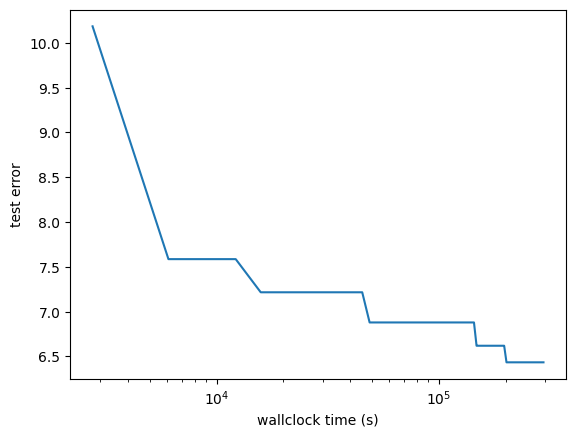

In [16]:
class RandomSearch(Optimizer):
    
    def _initialization(self) -> None:
        # start the random search loop
        for i in range(self.n_iters):
            
            # TODO: sample hyperparameter configuration
            config = self.cs.sample_configuration()
    
            # TODO: evaluate and store results
            self.evaluate_and_log(config)

    def run(self) -> None:
        self._initialization()

opt = RandomSearch(benchmark=b, n_iters=100)
opt.run()

plt.plot(opt.total_time, opt.incumbent_trajectory_error)
plt.xscale('log')
plt.ylabel("test error")
plt.xlabel("wallclock time (s)")

## 3. Bayesian optimization

Now we we will implement Bayesian optimization [[Snoek et al, 2012]](#4.-References).
As we saw in the lecture, Bayesian optimization has two main ingredients: the probablistic model and the acquisition function. Since we have a discrete space here, we will first use random forest [[Breimann et al, 2001]](#4.-References) to model the objective function instead of Gaussian processes which are the usually used for continuous spaces. For the acquisition function we will use upper confidence bound, probability of improvement and expected improvement, which are probably the most popular one in the literature. Additionaly, we also need an optimizer to maximize the acquisition function, and, due to the discrete space, we cannot use standard optimizer, such as for example `scipy.optimize`. Instead, we will implemented a simple stochastic local search method.

Let's start with the model. We will we write a wrapper around sklearn's random forest module, which returns for a given test point only the mean prediction. However, to compute the acquisition function, we also need the predictive variance. For that, we first loop over the trees to get the individual tree predictions and then compute the mean and variance of them.

In [5]:
from sklearn.ensemble import RandomForestRegressor

class RandomForest(object):
    def __init__(self, X: np.ndarray, y: np.ndarray) -> None:
        # TODO: Instantiate and fit a random forest on the provided data
        self.model = RandomForestRegressor()
        self.model.fit(X, y)

    def predict(self, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        # TODO: Loop over the tree estimators of the random forest and compute the
        # mean and variance over their predictions on X_test
        predictions = np.zeros((X_test.shape[0], len(self.model.estimators_)))
        for i, tree in enumerate(self.model.estimators_):
            predictions[:, i] = tree.predict(X_test)
        mean = np.mean(predictions, axis=1)
        var = np.var(predictions, axis=1)
        return mean, var


Next, we will implement the probability of improvement and expected improvement acquisition functions. To compute the CDF and the PDF you can use the scipy functions: `scipy.norm.cdf` and `scipy.norm.pdf`. Refer to the following link for more details on these acquisition functions: https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html

In [6]:
def ucb(candidates: np.ndarray, model, y_star: float) -> np.ndarray:
    """ Upper Confidence Bound Acquisition Function """
    explore_factor = 0.01
    mean, var = model.predict(candidates)
    sigma = np.sqrt(var)
    ucb = mean + explore_factor * sigma
    return ucb

In [7]:
from scipy.stats import norm

def ei(candidates: np.ndarray, model, y_star: float) -> np.ndarray:
    """ Expected Improvement Acquisition Function """
    # TODO: compute the improvement for the candidate points over y_star in expectation based on the model's predictions
    epsilon = 0.0000001 # add this to sigma in denominator to avoid division by 0
    explore_factor = 0.01
    mean, var = model.predict(candidates)
    sigma = np.sqrt(var)
    z = ((mean - y_star - epsilon) / (sigma + epsilon)) * explore_factor
    ei = (mean - y_star - epsilon) * norm.cdf(z) + sigma * norm.pdf(z)
    return ei

def pi(candidates: np.ndarray, model, y_star: float) -> np.ndarray:
    """ Probability of Improvement Acquisition Function """
    # TODO: compute the probability of model predictions being better than y_star
    epsilon = 0.0000001 # add this to sigma in denominator to avoid division by 0
    explore_factor = 0.01
    mean, var = model.predict(candidates)
    sigma = np.sqrt(var)
    z = ((mean - y_star - epsilon) / (sigma + epsilon)) * explore_factor
    pi = norm.cdf(z)
    return pi
    

As already mentioned above, to optimize the acquisition function we will implement a simple local search method, which works as follows:
 1. start from an initial point `x_init`
 2. loop over all its one-step neighbours and compute the acquisition function values
 3. jump to the neighbour with the highest acquisition function value
 4. repeat step 2 and 3 until we either reach the maximum number of steps `n_steps` or we don't improve anymore
 5. return best found configuration

In [8]:
from ConfigSpace.util import get_one_exchange_neighbourhood  # see docstring: https://github.com/automl/ConfigSpace/blob/master/ConfigSpace/util.pyx for more details

def local_search(acquisition_function, model, y_star: float,
                 x_init: ConfigSpace.Configuration, n_steps: int) -> ConfigSpace.Configuration:
    current_best = x_init
    current_best_value = acquisition_function(x_init.get_array()[None, :], model, y_star)
    for i in range(n_steps):

        # TODO: evaluate one-step neighbourhood (hint: use get_one_exchange_neighbourhood function)
        neighbors = get_one_exchange_neighbourhood(current_best, seed=i)
        neighbors = [n for n in neighbors if n != current_best]

        max_ei = current_best_value
        best_neighbor = None
        for neighbor in neighbors:
            # TODO: check whether we improved upon the current best
            value = acquisition_function(neighbor.get_array()[None, :], model, y_star)
            if value > max_ei:
                max_ei = value
                best_neighbor = neighbor

        # TODO: jump to the next neighbour if we improved.
        # In case we converged, stop the local search
        if best_neighbor is None:
            break
        current_best = best_neighbor
        current_best_value = max_ei

    return current_best

Now we have all our ingredients together, and we can finally implement the main Bayesian optimization loop.
Before we can fit a model, we need to collect some data first. This is called the initial design.
Various different initial design strategies exist, but here we will simply sample `n_init` random points.

Note that, like for random search, we want to benchmark Bayesian optimization later and need the performance of the incumbent over time. Make sure that you keep track of the incumbent and check after *each function evaluation* whether we improved.

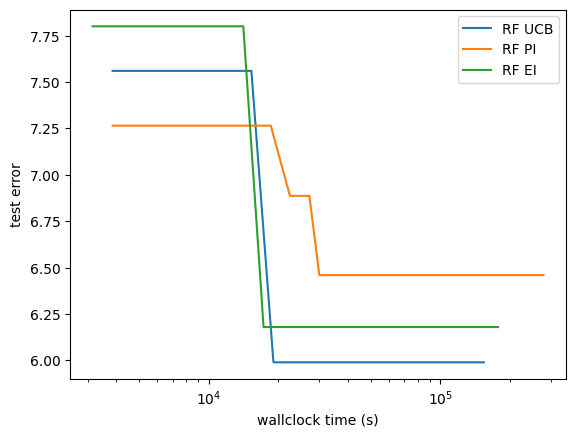

In [9]:
from functools import partial

class BayesianOptimization(RandomSearch):
    def run(self, model, acquisition_function=ei, optimizer=local_search):
        self._initialization()

        # start main BO loop
        for i in range(self.n_init, self.n_iters):
    
            # TODO: fit model
            X = np.array([c.get_array() for c in self.X])
            model_instance = model(X, np.array(self.y))
    
            # TODO: optimize acquisition function to get candidate point
            candidate = optimizer(acquisition_function, model_instance, self.incumbent_val, self.X[-1], n_steps=100)
    
            # TODO: evaluate objective function at the candidate point and update incumbent
            self.evaluate_and_log(candidate)

opt_ucb = BayesianOptimization(benchmark=b, n_iters=100, n_init=20)
opt_ucb.run(model=RandomForest, acquisition_function=ucb)
opt_pi = BayesianOptimization(benchmark=b, n_iters=100, n_init=20)
opt_pi.run(model=RandomForest, acquisition_function=pi)
opt_ei = BayesianOptimization(benchmark=b, n_iters=100, n_init=20)
opt_ei.run(model=RandomForest, acquisition_function=ei)

plt.plot(opt_ucb.total_time, opt_ucb.incumbent_trajectory_error, label='RF UCB')
plt.plot(opt_pi.total_time, opt_pi.incumbent_trajectory_error, label='RF PI')
plt.plot(opt_ei.total_time, opt_ei.incumbent_trajectory_error, label='RF EI')
plt.xscale('log')
plt.ylabel("test error")
plt.xlabel("wallclock time (s)")
plt.legend()

As an additional model we will try DNGO [[Snoek et al, 2015]](#4.-References), which first fits a neural networks with a linear output layer.
After training, it chops off the output layer and uses Bayesian linear regression with the output of the last layer as basis functions.
During inference time, it pass the test data through the first layers and then uses the precomputed Basis linear regression terms (m, K) to compute the mean and the variance. For more details have a look in Section 3 in the paper by [[Snoek et al, 2015]](#4.-References).

Text(0.5, 0, 'wallclock time (s)')

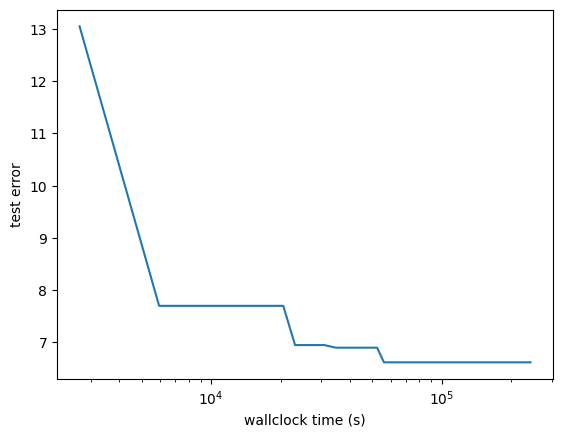

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, n_inputs, n_units=50):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_inputs, n_units)
        self.fc2 = nn.Linear(n_units, n_units)
        self.fc3 = nn.Linear(n_units, n_units)
        self.out = nn.Linear(n_units, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return self.out(x)

    def basis_funcs(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

class DNGO(object):
    
    def __init__(self, X: np.ndarray, y: np.ndarray, num_epochs: int = 200) -> None:
        if torch.cuda.is_available():
            device_name = 'cuda'
        else:
            device_name = 'cpu'
        self.device = torch.device(device_name)
        batch_size = 32
        learning_rate = 1e-4

        # TODO: instantiate the neural network
        self.dnn = Net(X.shape[1])
        self.dnn.to(self.device)

        # TODO: implement the training loop. Use the MSE loss and Adam optimizer
        optimizer = optim.Adam(self.dnn.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        self.dnn.train()
        for epoch in range(num_epochs):
            for i in range(0, X.shape[0], batch_size):
                inputs = torch.tensor(X[i:i+batch_size], dtype=torch.float32, device=self.device)
                targets = torch.tensor(y[i:i+batch_size], dtype=torch.float32, device=self.device)
                optimizer.zero_grad()
                outputs = self.dnn(inputs).squeeze(1)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        # Hyperparameters for the Bayesian linear regression.
        # Note: in the paper they sample \alpha an \beta from the marginal log-likelihood
        # However, for simplicity, we keep them fix
        self.alpha = 1E-3
        self.beta = 1000

        # TODO: compute the Bayesian linear regression terms
        self.dnn.eval()
        with torch.no_grad():
            basis_funcs = self.dnn.basis_funcs(torch.tensor(X, dtype=torch.float32, device=self.device))
            basis_funcs = basis_funcs.cpu().numpy()
            self.K = self.beta * np.dot(basis_funcs.T, basis_funcs) + (1 / self.alpha) * np.eye(basis_funcs.shape[1])
            self.K_inv = np.linalg.inv(self.K)
            self.m = self.beta * np.dot(self.K_inv, np.dot(basis_funcs.T, y))
        

    def predict(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:

        # TODO: extract the basis functions
        with torch.no_grad():
            basis_funcs = self.dnn.basis_funcs(torch.tensor(X, dtype=torch.float32, device=self.device))
            basis_funcs = basis_funcs.cpu().numpy()

        # TODO: compute the mean and the variance based on the Bayesian linear regression terms
        mean = np.dot(basis_funcs, self.m)
        variance = np.diag(np.dot(basis_funcs, np.dot(self.K_inv, basis_funcs.T))+ 1 / self.beta) 
        if variance < 0:
            print("variance: ", variance)
        return mean, variance


opt = BayesianOptimization(benchmark=b, n_iters=100, n_init=20)
opt.run(model=DNGO, acquisition_function=ei)

plt.plot(opt.total_time, opt.incumbent_trajectory_error)
plt.xscale('log')
plt.ylabel("test error")
plt.xlabel("wallclock time (s)")

## 4. Regularized Evolution

Below we will implement Regularized Evolution (RE) from [[Real et al. 2019]](#4.-References). We will again inherit from the `RandomSearch` class since RE initializes the population with randomly sampled architectures. We will then run the evolutionary search, where we need to mutate sampled parent architectures from the population. In the NAS-Bench-201 search space the mutations are just 2, namely `clone` and `op_mutation`. `edge_mutation` does not apply here since in NAS-Bench-201 the cell topology is fixed, and the search is only over the operation types on every edge.

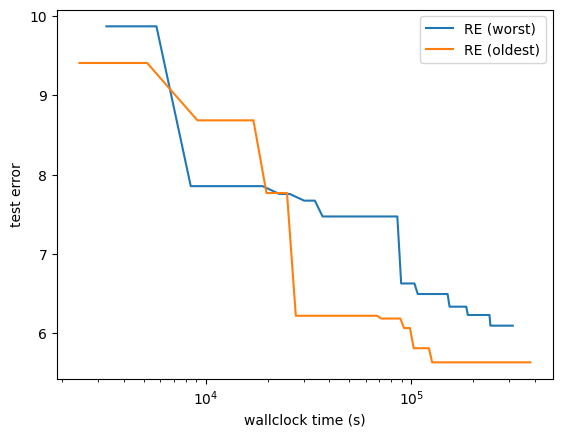

In [11]:
import random
from copy import deepcopy

class RegularizedEvolution(RandomSearch):

    def mutate(self, parent_config: ConfigSpace.Configuration) -> ConfigSpace.Configuration:
        mutation_type = random.choice(['clone', 'op_mutation'])
        if mutation_type == 'op_mutation':
            # TODO: pick one random edge out of the 6 edges in the cell
            # edges = ['op_0_to_1', 'op_0_to_2', 'op_0_to_3', 'op_1_to_2', 'op_1_to_3', 'op_2_to_3']
            # edge = random.choice(edges)
            edge = random.randint(0, 5)
            
            # TODO: swap the current operation type at this edge with a different
            # one sampled randomly (make sure it is not the same operation) from the operation list.
            # operations = ['zeroize', 'skip_connect', 'nor_conv_1x1', 'nor_conv_3x3', 'avg_pool_3x3']
            # operation = random.choice(operations)
            parent = parent_config.get_array()
            operation = random.randint(0, 4)
            
            while operation == parent[edge]:
                # operation = random.choice(operations)
                operation = random.randint(0, 4)
            child_arch = deepcopy(parent)
            child_arch[edge] = operation
            child_arch = ConfigSpace.Configuration(self.cs, vector=child_arch)
            # print(f"Mutated {str(edge)} from {str(parent_config[edge])} to {str(child_arch[edge])}")

        else:
            child_arch = parent_config
        return child_arch
    
    def run(self, sample_size: int=10, remove_oldest: bool=True) -> None:
        # initialize the population with random architectures
        self._initialization()
        population = [(arch, error) for arch, error in zip(self.X, self.y)]

        # start main RE loop
        for i in range(self.n_init, self.n_iters):
            sample = []
            # TODO: sample randomly "sample_size" architectures from the 
            # current population and add them to the "sample" list.
            sample = random.sample(population, sample_size)            

            # TODO: select the parent -- the best model in the sample.
            # NOTE: keep in mind that we use error here
            parent_arch, parent_error = min(sample, key=lambda x: x[1])

            # TODO: create the child model, evaluate and log it.
            child_arch = self.mutate(parent_arch)
            self.evaluate_and_log(child_arch)

            # TODO: append the tuple with the child_arch and its error to the population list
            population.append((child_arch, self.y[-1]))

            if remove_oldest:
                # TODO: remove the oldest architecture
                population.pop(0)
            else:
                # TODO: remove the worst architecture
                population.remove(max(population, key=lambda x: x[1]))

opt_worst = RegularizedEvolution(benchmark=b, n_iters=100, n_init=20)
opt_worst.run(remove_oldest=False)
opt_old = RegularizedEvolution(benchmark=b, n_iters=100, n_init=20)
opt_old.run(remove_oldest=True)

plt.plot(opt_worst.total_time, opt_worst.incumbent_trajectory_error, label='RE (worst)')
plt.plot(opt_old.total_time, opt_old.incumbent_trajectory_error, label='RE (oldest)')
plt.xscale('log')
plt.ylabel("test error")
plt.xlabel("wallclock time (s)")
plt.legend()

## 5. Experimental Evaluation

A major part in developing new optimizers is the empirical comparison to existing baselines.
Even though this is often cumbersome and frustrating, it is key to obtain a better understanding and hence to develop better methods.

Since the most algorithms are to a certain degree randomized, we need to perform independent runs of each method with a different intialization in order to draw statistical significant conclusions.
In practice, this is often problematic due to the high computational cost of the most NAS problems. With our tabular benchmarks however, we can easiliy afford multiple runs and are only limited by the optimizer's overhead.

In the code below we run each methods `10` times for `100` iterations and store the incumbent trajectories of each run. If we have parallel resources available, such as for instance with a compute cluster, it is good practice to parallelize everything as much as possible ot get the most efficient workload. However, since we compare only a few methods for a moderate number of runs and iterations, we can afford it to run them sequentially.

In [24]:
n_runs = 10
n_iters = 100
n_methods = 4 # RS, RE (oldest), BO (DNGO + EI), BO (RF + EI)

incumbent_error = np.zeros((n_methods, n_runs, n_iters))
incumbent = [[0 for y in range(n_runs)] for x in range(n_methods)]

# TODO: evaluate each method 'n_runs' times for 'n_iters' iterations and update 'incumbents' and 'incumbent_error'
methods = [RandomSearch, RegularizedEvolution, BayesianOptimization, BayesianOptimization]
dngo = False
for method in range(n_methods):
    method_class = methods[method]
    opt = method_class(benchmark=b, n_iters=n_iters, n_init=20)
    if method_class == BayesianOptimization:
        if dngo:
            for run in range(n_runs):
                opt.run(model=DNGO, acquisition_function=ei)
                index = run * n_iters
                incumbent_error[method, run] = opt.incumbent_trajectory_error[index:index+n_iters]
                incumbent[method][run] = opt.incumbent
        else:
            for run in range(n_runs):
                opt.run(model=RandomForest, acquisition_function=ei)
                index = run * n_iters
                incumbent_error[method, run] = opt.incumbent_trajectory_error[index:index+n_iters]
                incumbent[method][run] = opt.incumbent
            dngo = True

    else:
        for run in range(n_runs):
            opt.run()
            index = run * n_iters
            incumbent_error[method, run] = opt.incumbent_trajectory_error[index:index+n_iters]
            incumbent[method][run] = opt.incumbent


Another nice property of the tabular benchmarks is that we know the true global optimum (in terms of test error averaged over the four trials).
To estimate an optimzer's quality, a popular metric is the regret: $|y_{incumbent} - y_{\star}|$ which measures the difference between the performance $y_{\star}$ of the global optimum and the current incumbent performance $y_{incumbent}$.

In [25]:
_, y_star = b.get_best_configuration()

To get a robust estimated of an optimzer's performance, we first compute the regret and then plot the incumbent trajectory across all independent runs of each optimzer

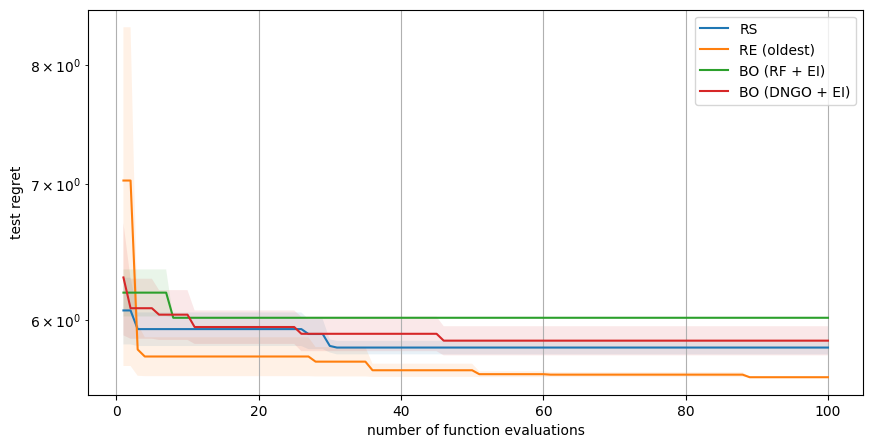

In [26]:
# TODO: compute the mean and standard of the incumbent_error over all runs
# https://en.wikipedia.org/wiki/Standard_error
mean_incumbent_error = np.mean(incumbent_error, axis=1)
incumbent_se = np.std(incumbent_error, axis=1) / np.sqrt(n_runs)

x = np.arange(1, mean_incumbent_error.shape[1] + 1) # n_iters
# TODO: plot mean regret for every method together with the standard error (use pyplot.fill_between)
plt.figure(figsize=(10, 5))
plt.fill_between(x, mean_incumbent_error[0] - incumbent_se[0], mean_incumbent_error[0] + incumbent_se[0], alpha=0.1)
plt.plot(x, mean_incumbent_error[0], label='RS')
plt.fill_between(x, mean_incumbent_error[1] - incumbent_se[1], mean_incumbent_error[1] + incumbent_se[1], alpha=0.1)
plt.plot(x, mean_incumbent_error[1], label='RE (oldest)')
plt.fill_between(x, mean_incumbent_error[2] - incumbent_se[2], mean_incumbent_error[2] + incumbent_se[2], alpha=0.1)
plt.plot(x, mean_incumbent_error[2], label='BO (RF + EI)')
plt.fill_between(x, mean_incumbent_error[3] - incumbent_se[3], mean_incumbent_error[3] + incumbent_se[3], alpha=0.1)
plt.plot(x, mean_incumbent_error[3], label='BO (DNGO + EI)')
plt.yscale('log')

plt.ylabel("test regret")
plt.xlabel("number of function evaluations")
plt.legend()
plt.grid()

Typically in NAS, the search is done on a small dataset such as CIFAR-10 and the found cells are transferred to a more expensive dataset such as ImageNet and only evaluated (no search done anymore on ImageNet). Thus, it is also good practice to perform an offline evaluation to compute the performance on ImageNet of all incumbents.
The tabular benchmarks allow us to do that efficiently and, as for the ImageNet performance, we can again compute the regret to the true performance (y_star_imagenet).

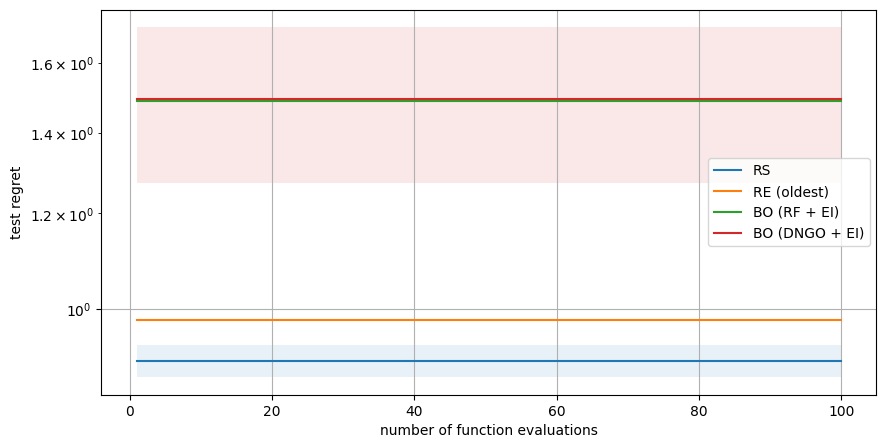

In [27]:
b_imagenet = NB201Benchmark(path="./nb201.pkl", dataset='imagenet16')
_, y_star_imagenet = b_imagenet.get_best_configuration()

incumbent_error_imagenet = np.zeros((n_methods, n_runs, n_iters))

# TODO: compute test performance for all methods and all runs and then the average test regret +/- standard error on ImageNet
# HINT: only need to evaluate what we appended to the "incumbent" list
for method in range(n_methods):
    for run in range(n_runs):
        config = incumbent[method][run]
        error, _ = b_imagenet.objective_function(config)
        incumbent_error_imagenet[method, run] = error

mean_incumbent_error_imagenet = np.mean(incumbent_error_imagenet, axis=1)
incumbent_se_imagenet = np.std(incumbent_error_imagenet, axis=1) / np.sqrt(n_runs)
regret_graph_test = mean_incumbent_error_imagenet - y_star_imagenet

# TODO: plot mean regret on ImageNet for every method together with the standard error (use pyplot.fill_between)
plt.figure(figsize=(10, 5))
plt.fill_between(x, regret_graph_test[0] - incumbent_se_imagenet[0], regret_graph_test[0] + incumbent_se_imagenet[0], alpha=0.1)
plt.plot(x, regret_graph_test[0], label='RS')
plt.fill_between(x, regret_graph_test[1] - incumbent_se_imagenet[1], regret_graph_test[1] + incumbent_se_imagenet[1], alpha=0.1)
plt.plot(x, regret_graph_test[1], label='RE (oldest)')
plt.fill_between(x, regret_graph_test[2] - incumbent_se_imagenet[2], regret_graph_test[2] + incumbent_se_imagenet[2], alpha=0.1)
plt.plot(x, regret_graph_test[2], label='BO (RF + EI)')
plt.fill_between(x, regret_graph_test[3] - incumbent_se_imagenet[3], regret_graph_test[3] + incumbent_se_imagenet[3], alpha=0.1)
plt.plot(x, regret_graph_test[3], label='BO (DNGO + EI)')
plt.yscale('log')

plt.ylabel("test regret")
plt.xlabel("number of function evaluations")
plt.legend()
plt.grid()

## 6. References

* L. Breimann (2001) *Random Forests*  Machine Learning
* J. Bergstra and Y. Bengio (2012) *Random Search for Hyper-Parameter Optimization* Journal of Machine Learning Research 
* B. Shahriari and K. Swersky and Z. Wang and R. Adams and N. de Freitas (2016), *Taking the Human Out of the Loop: {A} Review of {B}ayesian Optimization* Proceedings of the {IEEE}
* J. Snoek and H. Larochelle and R. P. Adams (2012) *Practical {B}ayesian Optimization of Machine Learning Algorithms* Proceedings of the 25th International Conference on Advances in Neural Information Processing Systems (NIPS'12)
* J. Snoek and O. Rippel and K. Swersky and R. Kiros and N. Satish and N. Sundaram and M. Patwary and Prabhat and R. Adams (2015) *Scalable {B}ayesian Optimization Using Deep Neural Networks* Proceedings of the 32nd International Conference on Machine Learning (ICML'15)
* X. Dong, Y. Yang (2020) *NAS-Bench-201: Extending the Scope of Reproducible Neural Architecture Search* ICLR 2020
* E. Real, A. Aggarwal, Y. Huang, Q. V. Le (2019) *Regularized Evolution for Image Classifier Architecture Search* AAAI 2019